In [1]:
import numpy as np
from tqdm import tqdm, trange
from data import Catalogue

In [2]:
n_2_bn = lambda x: '_'.join(x.split('_')[:3])

In [3]:
base_names_0 = set()
for i in trange(10):
    cat_names = Catalogue.get_names(f'E:/new_dset_0/cat_{i:02d}.lat')
    base_names_0.update([n_2_bn(name) for name in cat_names])

base_names_1 = set()
for i in trange(10):
    cat_names = Catalogue.get_names(f'E:/new_dset_1/cat_{i:02d}.lat')
    base_names_1.update([n_2_bn(name) for name in cat_names])

# find set intersection
base_names = base_names_0.intersection(base_names_1)
print(f'Number of base names: {len(base_names)}')

100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

Number of base names: 9041


In [ ]:
print(f'Number of base names: {len(base_names)}')

Number of base names: 9041


In [4]:
# load the compliance tensors from both datasets and make sure that they match
# for the lattices without imperfections
# load only the intersecting base lattices and only zero imperfections
cat_0_lines = dict()
with trange(10) as t:
    for i in t:
        cat = Catalogue.from_file(f'E:/new_dset_0/cat_{i:02d}.lat', 0, regex=r'.*p_0.0_.*')
        cat_lines = cat.lines
        # keep only the base lattices that are in the intersection
        cat_lines = {name:line for name, line in cat_lines.items() if (n_2_bn(name) in base_names)}
        cat_0_lines.update(cat_lines)
        t.set_postfix({'cat_0_lines': len(cat_0_lines)})

cat_1_lines = dict()
with trange(10) as t:
    for i in t:
        cat = Catalogue.from_file(f'E:/new_dset_1/cat_{i:02d}.lat', 0, regex=r'.*p_0.0_.*')
        cat_lines = cat.lines
        # keep only the base lattices that are in the intersection
        cat_lines = {name:line for name, line in cat_lines.items() if (n_2_bn(name) in base_names)}
        cat_1_lines.update(cat_lines)
        t.set_postfix({'cat_1_lines': len(cat_1_lines)})


100%|██████████| 10/10 [00:58<00:00,  5.85s/it, cat_1_lines=9041]


In [5]:
# match lattice names to base names in both catalogues
bnames_0 = {}
for name in cat_0_lines:
    bname = '_'.join(name.split('_')[:3])
    imp_level = float(name.split('_')[4])
    if imp_level==0.0:
        bnames_0[bname] = name
bnames_1 = {}
for name in cat_1_lines:
    bname = '_'.join(name.split('_')[:3])
    imp_level = float(name.split('_')[4])
    if imp_level==0.0:
        bnames_1[bname] = name

cat_0 = Catalogue(cat_0_lines, 0)
cat_1 = Catalogue(cat_1_lines, 0)

In [8]:
compl_errors = {}
stiff_errors = {}
identity_errors = {}
for bname in tqdm(base_names):
    assert bname in bnames_0, f'{bname} not in bnames_0'
    assert bname in bnames_1, f'{bname} not in bnames_1'    
    S0 = cat_0[bnames_0[bname]]['compliance_tensors']
    S1 = cat_1[bnames_1[bname]]['compliance_tensors']
    assert sorted(S0.keys()) == sorted(S1.keys()), f'{bname} has different relative densities'
    S0 = np.stack([S0[rel_dens] for rel_dens in sorted(S0.keys())], axis=0)
    S1 = np.stack([S1[rel_dens] for rel_dens in sorted(S1.keys())], axis=0)
    C0 = np.linalg.inv(S0)
    C1 = np.linalg.inv(S1)
    # how do we define error? If with respect to the component itself, we will have huge errors
    rel_err = np.abs(S0-S1)/(0.5*(S0+S1)) # make sure it is symmetric
    compl_errors[bname] = rel_err.mean()
    rel_err = np.abs(C0-C1)/(0.5*(C0+C1)) # make sure it is symmetric
    stiff_errors[bname] = rel_err.mean()
    eye = np.eye(6)
    identity_error = np.abs(S0@C1 - eye[None,:,:]).mean() + np.abs(S1@C0 - eye[None,:,:]).mean()
    identity_errors[bname] = identity_error

  4%|▍         | 385/9041 [00:00<00:15, 564.22it/s]C:\Users\ig348\AppData\Local\Temp\ipykernel_60104\1488923127.py:15: RuntimeWarning: divide by zero encountered in true_divide
  rel_err = np.abs(S0-S1)/(0.5*(S0+S1)) # make sure it is symmetric
100%|██████████| 9041/9041 [00:16<00:00, 551.90it/s]


In [9]:
with np.printoptions(precision=3, suppress=True):
    print(bname)
    print('5% relative density')
    print(S0[-1])
    print(S1[-1])
    print('0.1% relative density')
    print(S0[0])
    print(S1[0])

trig_Z03.4_E1574
5% relative density
[[  674.97   -361.87   -243.23  -1007.6     -10.822    -0.138]
 [ -361.87    674.74   -243.22   1007.4      10.765     0.192]
 [ -243.23   -243.22    538.01     -0.057    -0.129     0.114]
 [-1007.6    1007.4      -0.057  2383.5       0.001    21.953]
 [  -10.822    10.765    -0.129     0.001  2383.3   -2015.2  ]
 [   -0.138     0.192     0.114    21.953 -2015.2    2074.1  ]]
[[  674.85   -361.91   -243.25  -1007.4     -10.867    -0.288]
 [ -361.91    675.07   -243.31   1007.6      10.874     0.227]
 [ -243.25   -243.31    538.1      -0.04      0.139    -0.1  ]
 [-1007.4    1007.6      -0.04   2383.3      -0.044    22.305]
 [  -10.867    10.874     0.139    -0.044  2382.8   -2014.6  ]
 [   -0.288     0.227    -0.1      22.305 -2014.6    2073.2  ]]
0.1% relative density
[[ 1427300.    -812630.    -610820.   -2467800.      -1547.1       565.05]
 [ -812630.    1427900.    -611300.    2468600.        404.5       645.92]
 [ -610820.    -611300.    122390

In [10]:
with np.printoptions(precision=3, suppress=True):
    print(bname)
    print(S0[0])
    print(S1[0])
    print(rel_err[0])

trig_Z03.4_E1574
[[ 1427300.    -812630.    -610820.   -2467800.      -1547.1       565.05]
 [ -812630.    1427900.    -611300.    2468600.        404.5       645.92]
 [ -610820.    -611300.    1223900.       -583.11      134.24     -213.26]
 [-2467800.    2468600.       -583.11  5462300.       -960.75     3007.5 ]
 [   -1547.1       404.5       134.24     -960.75  5463200.   -4939200.  ]
 [     565.05      645.92     -213.26     3007.5  -4939200.    4484800.  ]]
[[ 1435000.    -811660.    -615100.   -2471700.       6492.4    -12604.  ]
 [ -811660.    1426900.    -611160.    2467300.       1394.4     -1246.  ]
 [ -615100.    -611160.    1224300.        591.98    -2849.9      8340.2 ]
 [-2471700.    2467300.        591.98  5463000.       -326.21     6670.5 ]
 [    6492.4      1394.4     -2849.9      -326.21  5461300.   -4949800.  ]
 [  -12604.      -1246.       8340.2      6670.5  -4949800.    4507400.  ]]
[[ 0.095  0.113  0.095  0.084  2.469  2.499]
 [ 0.113  0.017  0.039 -0.026  2.556

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
df = pd.concat([pd.Series(compl_errors, name='compliance'), pd.Series(stiff_errors, name='stiffness'), pd.Series(identity_errors, name='identity')], axis=1)
df

,compliance,stiffness,identity
tet_Z03.6_E9917,-21.630208,2.369187,0.027785
tet_Z04.0_E3835,-0.125988,0.253958,0.189242
ort_Z04.0_E3273,0.538169,0.126372,0.034287
ort_Z04.5_E3758,0.415696,-0.190766,0.047561
cub_Z08.0_E5115,-2.011704,6.512869,0.017760
...,...,...,...
tet_Z04.3_E3767,0.856143,-1.152491,0.036839
ort_Z06.0_E5067,-1.650791,0.014178,0.015063
cub_Z04.5_E9030,-0.674827,0.964125,0.002573
cub_Z04.8_E12784,0.246828,-1.074650,0.007506


Could find examples where both compliance and stiffness errors are low but identity error is large

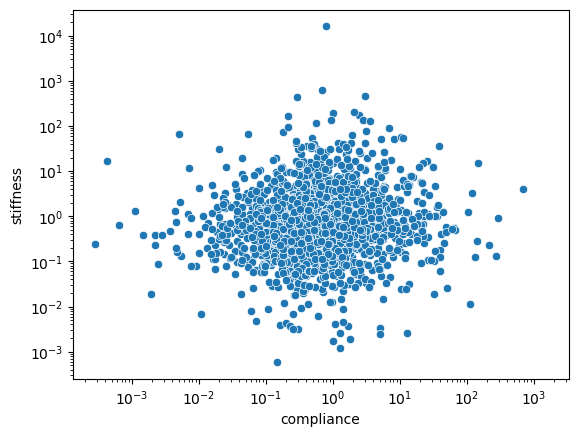

In [17]:
sns.scatterplot(data=df, x='compliance', y='stiffness')
plt.xscale('log')
plt.yscale('log')
# no correlation

c:\ProgramData\Anaconda3\envs\GLAMMenv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


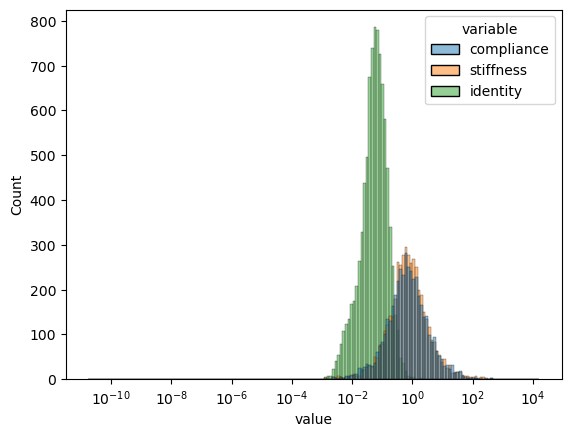

In [18]:
df_plot = df.melt()
sns.histplot(data=df_plot, x='value', hue='variable', log_scale=True)
plt.show()

c:\ProgramData\Anaconda3\envs\GLAMMenv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


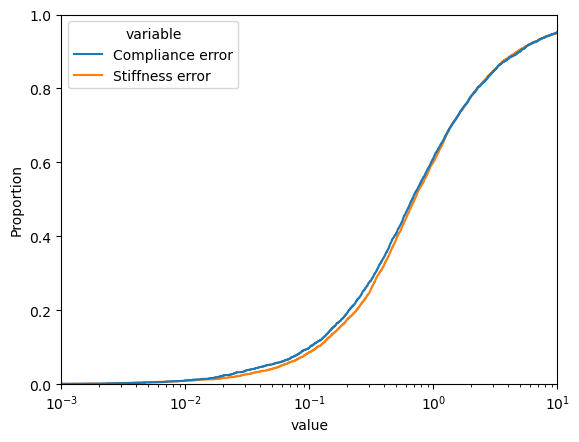

In [14]:
sns.ecdfplot(data=df, x='value', hue='variable', log_scale=True)
plt.xlim(1e-3, 1e1)
plt.show()

In [15]:
sorted_errors = sorted(compl_errors.items(), key=lambda x: x[1])
compl_names = [bname for bname, error in sorted_errors[:8200]]
sorted_errors = sorted(stiff_errors.items(), key=lambda x: x[1])
stiff_names = [bname for bname, error in sorted_errors[:8200]]
best_base_names = set(compl_names).intersection(stiff_names)
len(best_base_names)

7439

In [16]:
# want to plot parity plots. Assemble data into a multidimensional array: [num_lats, num_reldens, 6, 6]
num_reldens = 10
num_lats = len(base_names)
S0 = np.zeros((num_lats, num_reldens, 6, 6))
S1 = np.zeros_like(S0)
C0 = np.zeros_like(S0)
C1 = np.zeros_like(S0)
rel_dens = np.zeros((num_lats, num_reldens))

for i_lat, bname in enumerate(tqdm(base_names)):
    _s0 = cat_0[bnames_0[bname]]['compliance_tensors']
    _s1 = cat_1[bnames_1[bname]]['compliance_tensors']
    assert sorted(_s0.keys()) == sorted(_s1.keys()), f'{bname} has different relative densities'
    # make sure we have the required number of relative densities
    assert len(_s0.keys()) == num_reldens, f'{bname} has {len(_s0.keys())} relative densities, but we want {num_reldens}'
    rel_dens[i_lat, :] = sorted(_s0.keys())
    _s0 = np.stack([_s0[rel_dens] for rel_dens in sorted(_s0.keys())], axis=0)
    _s1 = np.stack([_s1[rel_dens] for rel_dens in sorted(_s1.keys())], axis=0)
    S0[i_lat, :, :, :] = _s0
    S1[i_lat, :, :, :] = _s1
    C0[i_lat, :, :, :] = np.linalg.inv(_s0)
    C1[i_lat, :, :, :] = np.linalg.inv(_s1)

  0%|          | 0/9041 [00:00<?, ?it/s]

100%|██████████| 9041/9041 [00:14<00:00, 627.86it/s]


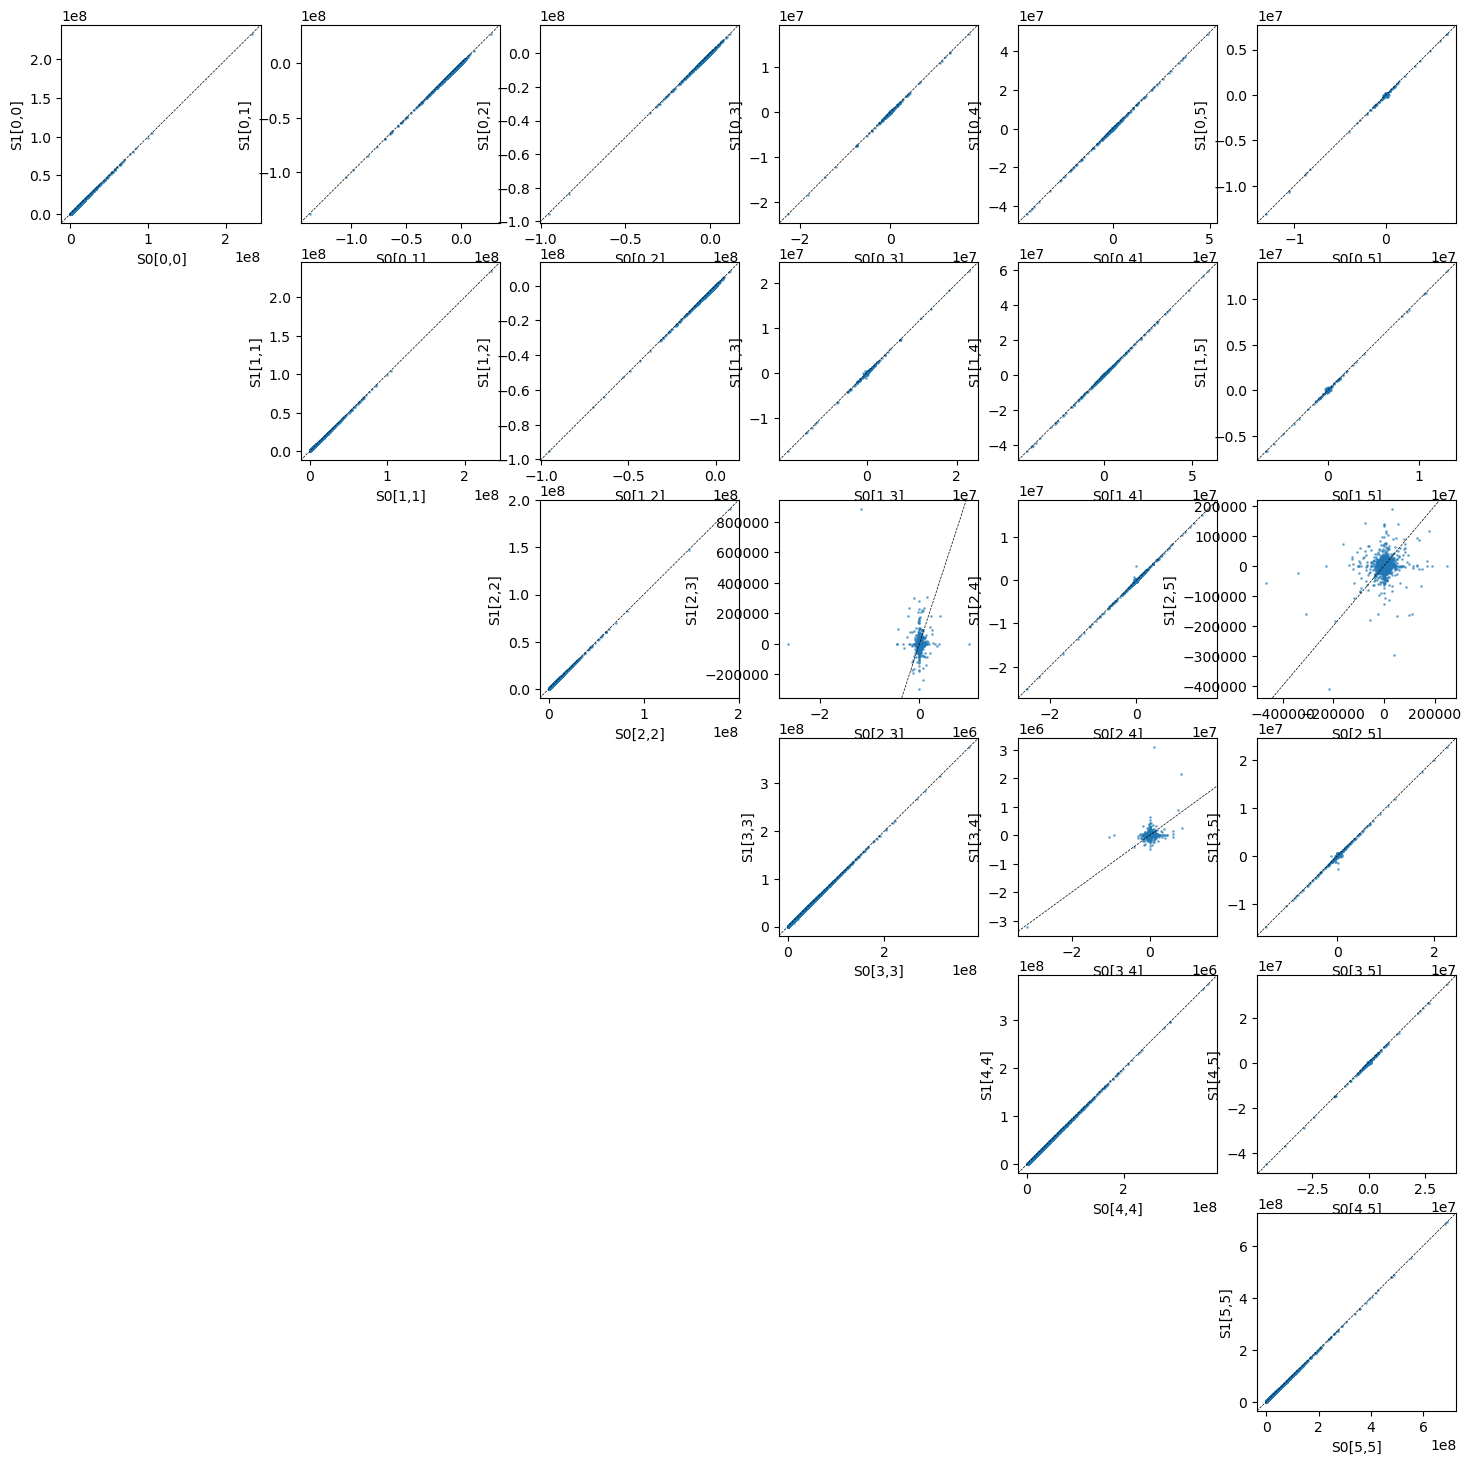

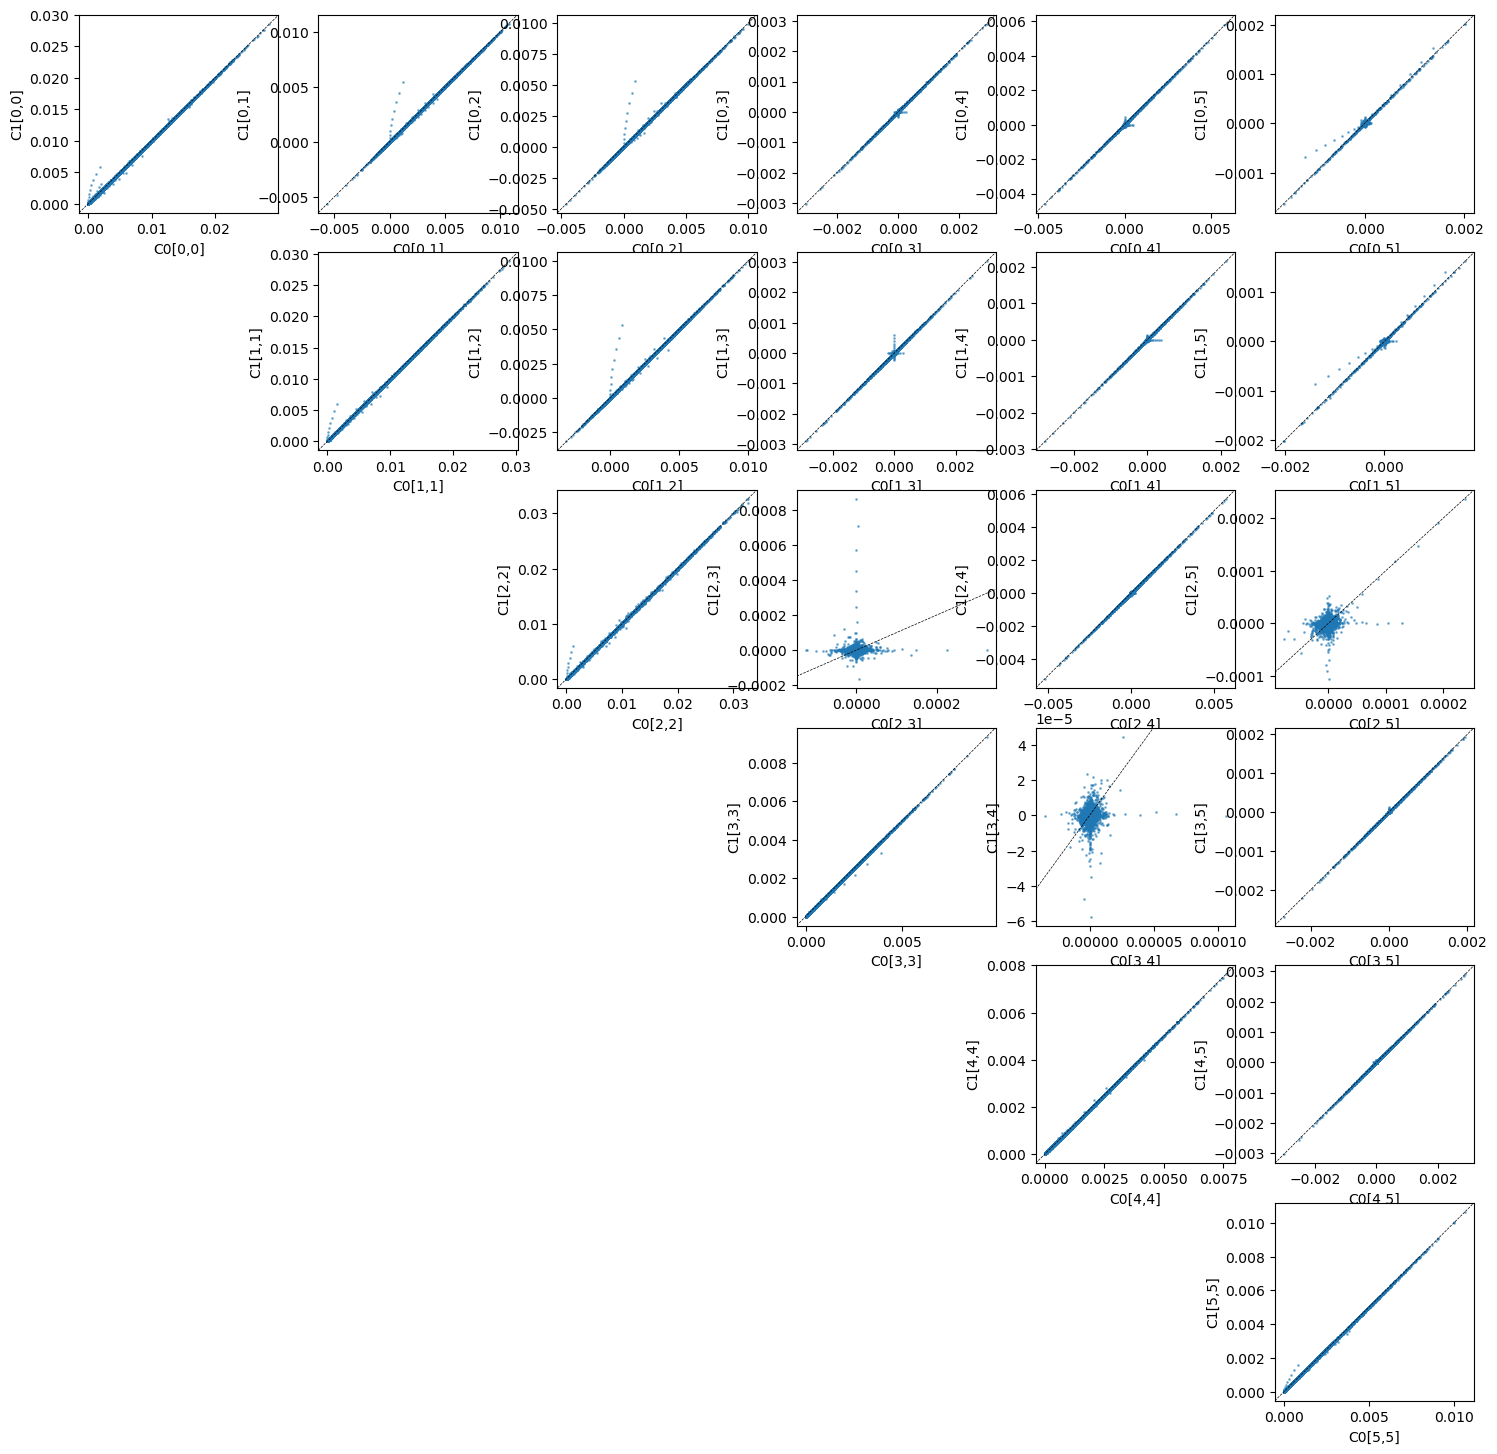

In [17]:
# plot parity plots on a 6x6 grid (only upper triangular)
# flatten all dimensions except for the last two
S0_plot = S0.reshape(-1, S0.shape[-2], S0.shape[-1])
S1_plot = S1.reshape(-1, S1.shape[-2], S1.shape[-1])
C0_plot = C0.reshape(-1, C0.shape[-2], C0.shape[-1])
C1_plot = C1.reshape(-1, C1.shape[-2], C1.shape[-1])
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18,18))
for i in range(6):
    for j in range(6):
        if i <= j:
            ax[i,j].scatter(S0_plot[:,i,j], S1_plot[:,i,j], s=1, alpha=0.5)
            ax[i,j].set_xlabel(f'S0[{i},{j}]')
            ax[i,j].set_ylabel(f'S1[{i},{j}]')
            ax[i,j].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
        else:
            ax[i,j].axis('off')
plt.show()
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18,18))
for i in range(6):
    for j in range(6):
        if i <= j:
            ax[i,j].scatter(C0_plot[:,i,j], C1_plot[:,i,j], s=1, alpha=0.5)
            ax[i,j].set_xlabel(f'C0[{i},{j}]')
            ax[i,j].set_ylabel(f'C1[{i},{j}]')
            ax[i,j].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
        else:
            ax[i,j].axis('off')
plt.show()

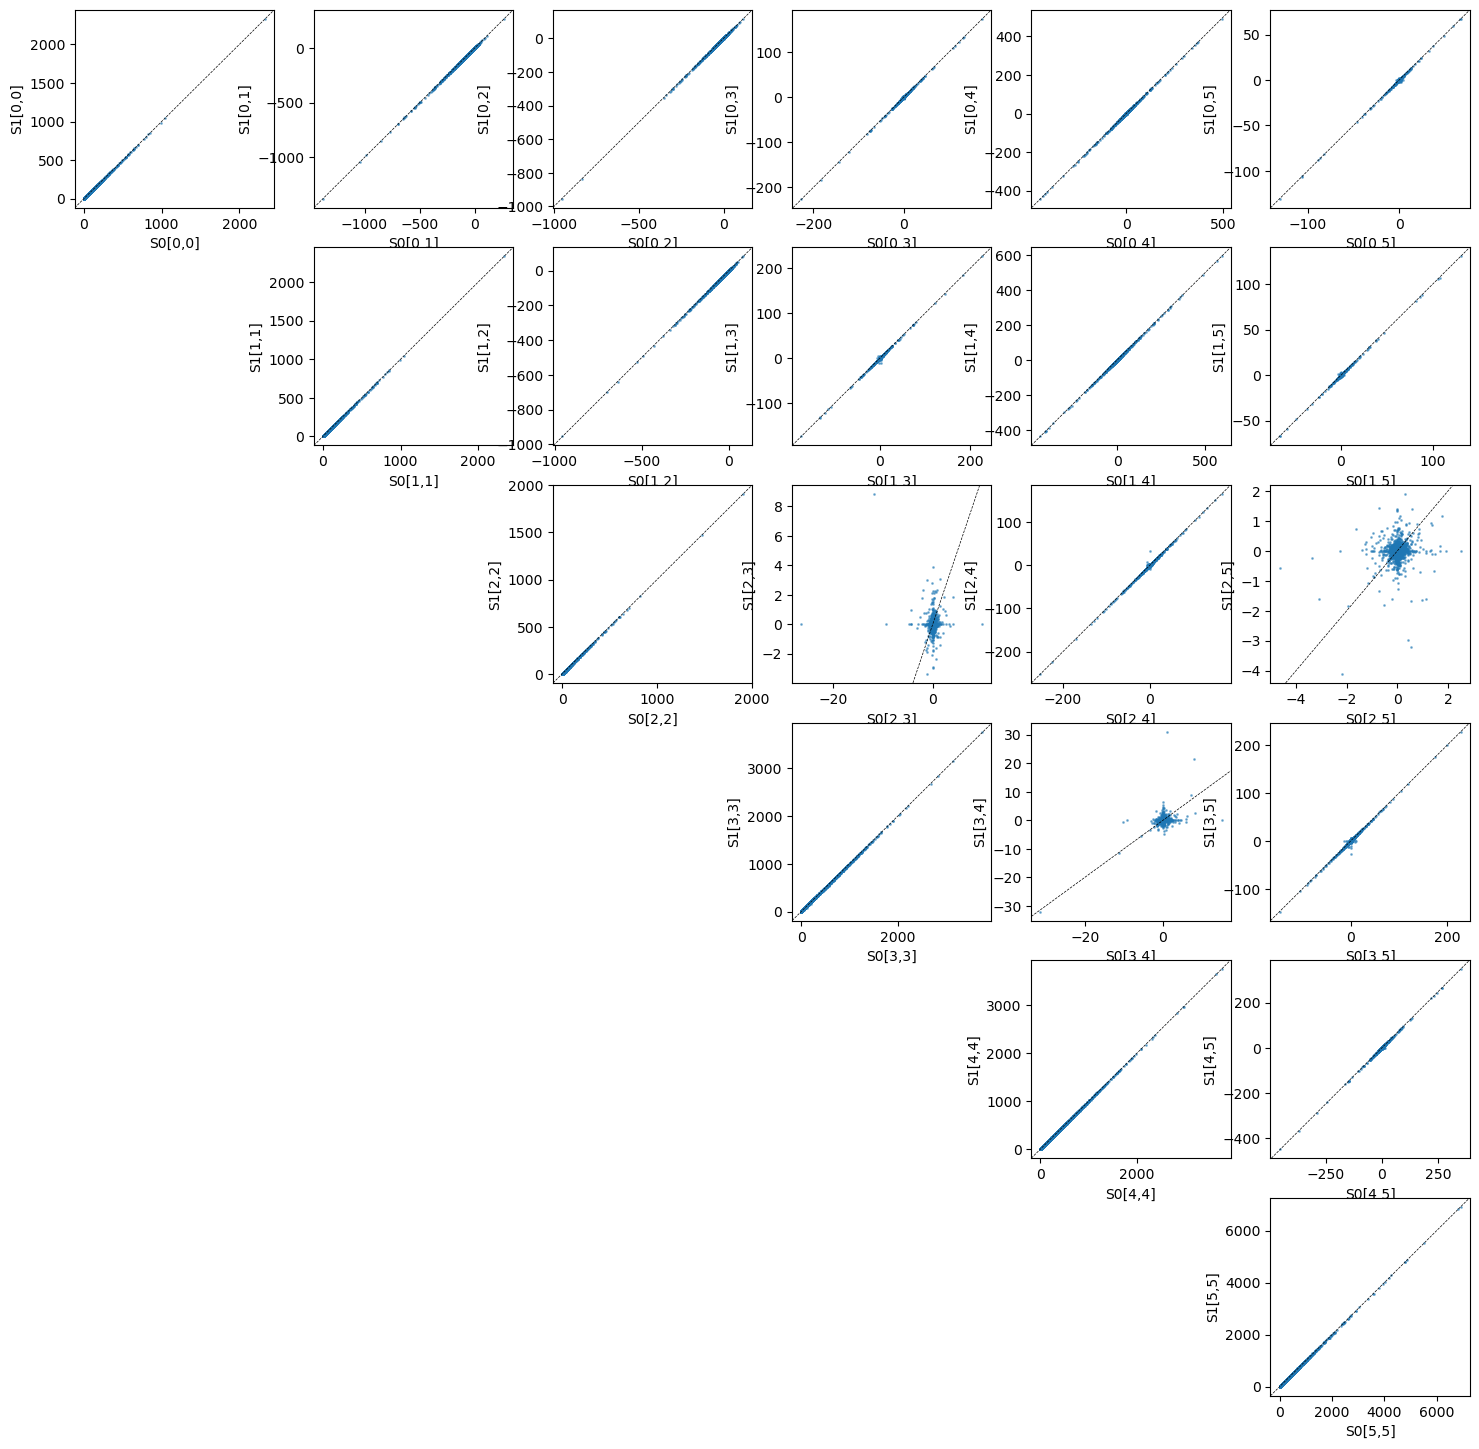

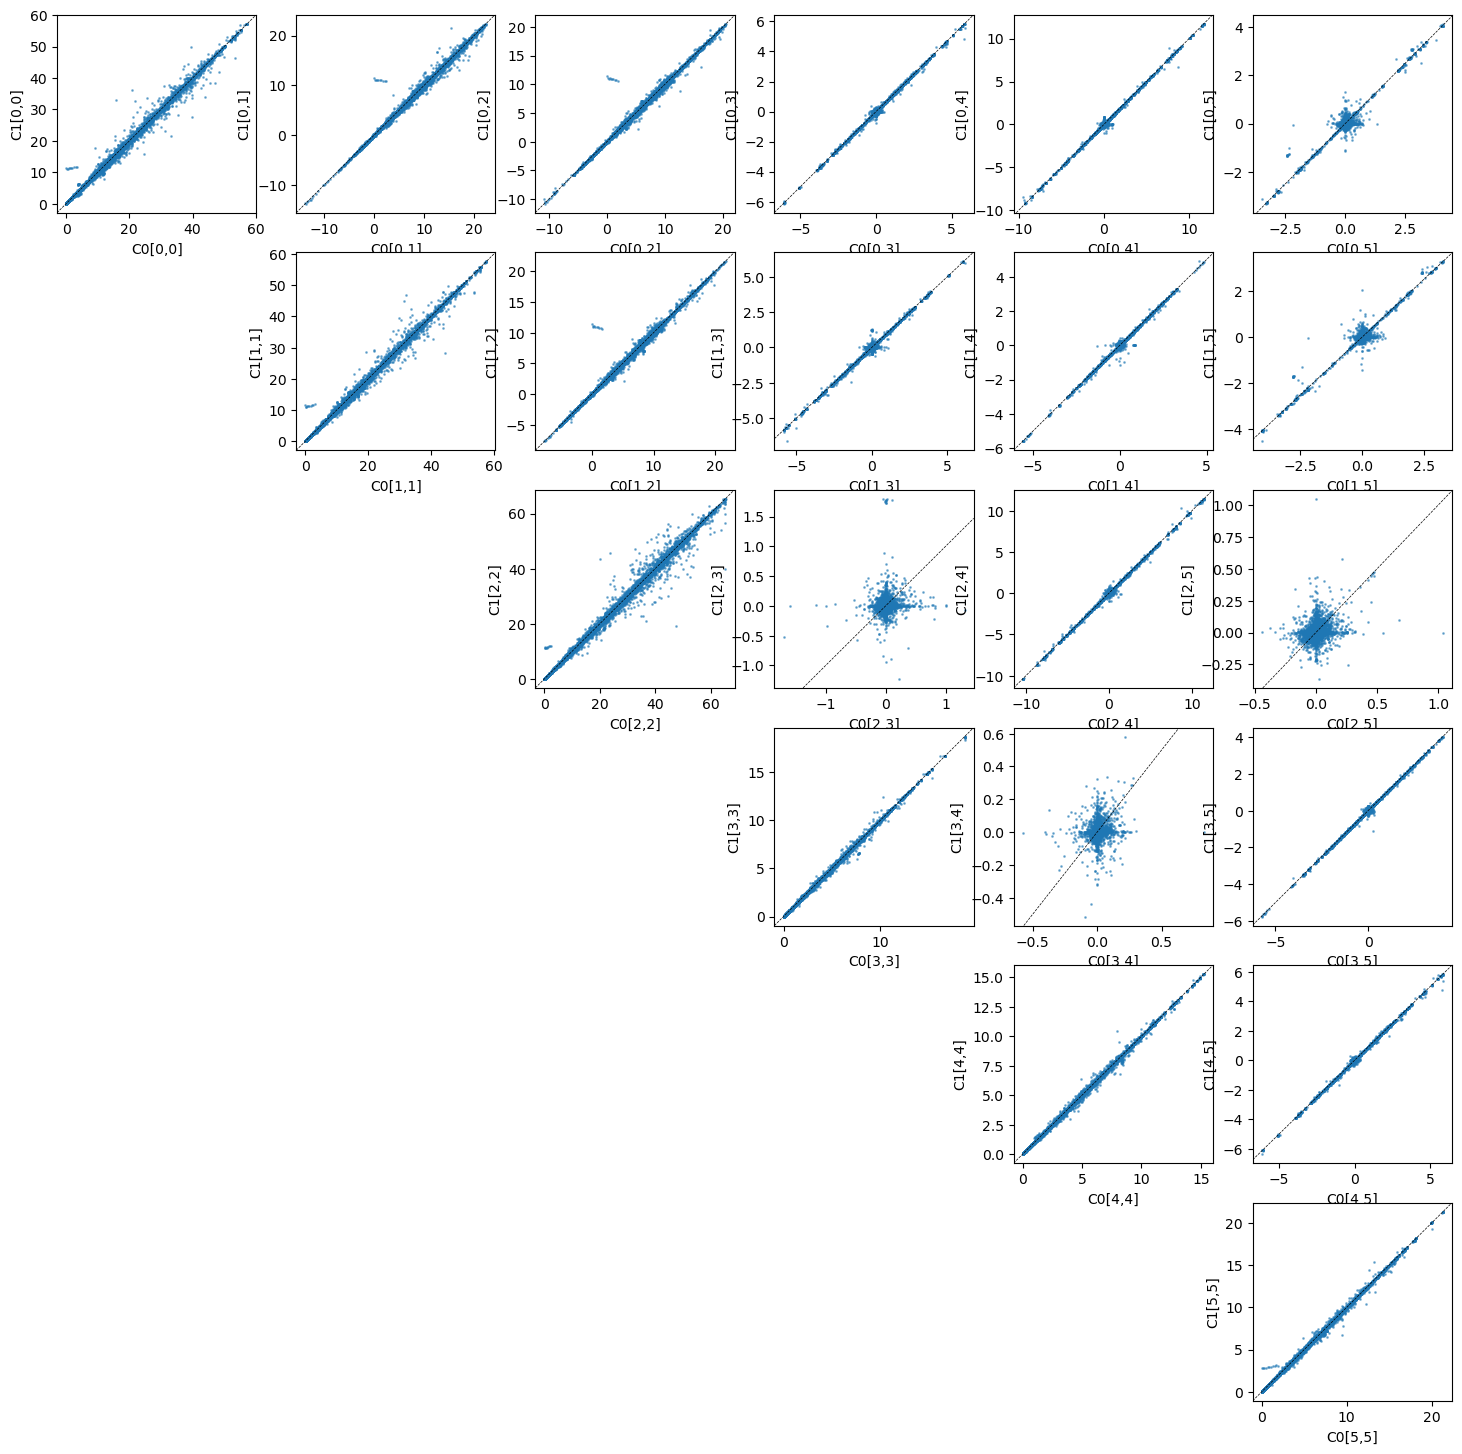

In [18]:
# Normalization as in ML
S0_plot = (S0*rel_dens[:,:,None,None]).reshape(-1, S0.shape[-2], S0.shape[-1])/100
S1_plot = (S1*rel_dens[:,:,None,None]).reshape(-1, S1.shape[-2], S1.shape[-1])/100
C0_plot = (C0/rel_dens[:,:,None,None]).reshape(-1, C0.shape[-2], C0.shape[-1])*100
C1_plot = (C1/rel_dens[:,:,None,None]).reshape(-1, C1.shape[-2], C1.shape[-1])*100
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18,18))
for i in range(6):
    for j in range(6):
        if i <= j:
            ax[i,j].scatter(S0_plot[:,i,j], S1_plot[:,i,j], s=1, alpha=0.5)
            ax[i,j].set_xlabel(f'S0[{i},{j}]')
            ax[i,j].set_ylabel(f'S1[{i},{j}]')
            ax[i,j].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
        else:
            ax[i,j].axis('off')
plt.show()
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18,18))
for i in range(6):
    for j in range(6):
        if i <= j:
            ax[i,j].scatter(C0_plot[:,i,j], C1_plot[:,i,j], s=1, alpha=0.5)
            ax[i,j].set_xlabel(f'C0[{i},{j}]')
            ax[i,j].set_ylabel(f'C1[{i},{j}]')
            ax[i,j].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
        else:
            ax[i,j].axis('off')
plt.show()

In [52]:
with np.printoptions(precision=3, suppress=True):
    print(S0_plot[0]@C0_plot[0])
    print(S0_plot[0]@C1_plot[0])

[[ 1.  0. -0. -0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [-0. -0.  1. -0.  0.  0.]
 [-0. -0.  0.  1.  0. -0.]
 [ 0. -0.  0.  0.  1. -0.]
 [-0. -0. -0.  0.  0.  1.]]
[[ 0.905 -0.017  0.004 -0.003  0.     0.   ]
 [ 0.006  0.974  0.014 -0.     0.    -0.   ]
 [-0.     0.027  1.022 -0.002  0.     0.   ]
 [-0.011 -0.005 -0.004  1.051 -0.     0.   ]
 [ 1.147  0.895  0.7   -0.086  1.004  0.   ]
 [ 4.151  1.244  0.118  1.119  0.002  1.   ]]


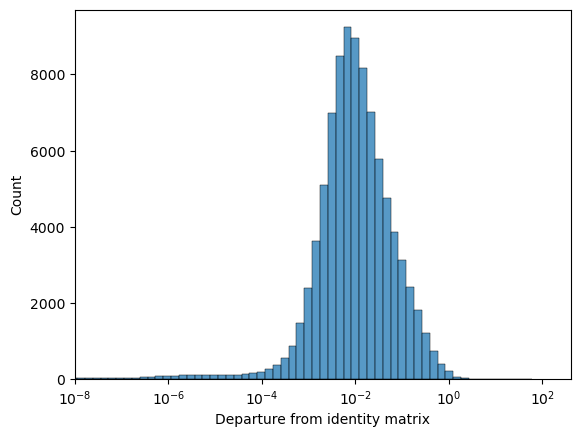

In [81]:
# plot the histogram of S0@C1 - I
eye = np.eye(6)
predicted_eye = S0_plot @ C1_plot
difference = predicted_eye - eye[None, :, :]
# average over the last two axes
difference = np.mean(np.abs(difference), axis=(1, 2))
sns.histplot(difference, bins=100, log_scale=True)
plt.xlim(left=1e-8)
plt.xlabel('Departure from identity matrix')
plt.show()

In [21]:
from data import elasticity_func
import torch # torch uses the entire cpu so the contractions will be faster

In [41]:
# See what errors we get in terms of projections of the tensors into 500 directions on the unit sphere
directions = torch.randn(100, 3, dtype=torch.double)
directions = directions / directions.norm(dim=1, keepdim=True)
orig_shape = S0.shape
S0_4 = torch.from_numpy(elasticity_func.compliance_Voigt_to_4th_order(S0.reshape(-1,6,6)).reshape(orig_shape[0], orig_shape[1], 3, 3, 3, 3))
S1_4 = torch.from_numpy(elasticity_func.compliance_Voigt_to_4th_order(S1.reshape(-1,6,6)).reshape(orig_shape[0], orig_shape[1], 3, 3, 3, 3))
C0_4 = torch.from_numpy(elasticity_func.stiffness_Voigt_to_4th_order(C0.reshape(-1,6,6)).reshape(orig_shape[0], orig_shape[1], 3, 3, 3, 3))
C1_4 = torch.from_numpy(elasticity_func.stiffness_Voigt_to_4th_order(C1.reshape(-1,6,6)).reshape(orig_shape[0], orig_shape[1], 3, 3, 3, 3))
print('S0_4.shape: ', S0_4.shape)

S0_4.shape:  torch.Size([9041, 10, 3, 3, 3, 3])


In [42]:
s0 = torch.einsum('...ijkl,pi,pj,pk,pl->...p', S0_4, directions, directions, directions, directions).numpy()
s1 = torch.einsum('...ijkl,pi,pj,pk,pl->...p', S1_4, directions, directions, directions, directions).numpy()
c0 = torch.einsum('...ijkl,pi,pj,pk,pl->...p', C0_4, directions, directions, directions, directions).numpy()
c1 = torch.einsum('...ijkl,pi,pj,pk,pl->...p', C1_4, directions, directions, directions, directions).numpy()
print('s0.shape', s0.shape)

s0.shape (9041, 10, 100)


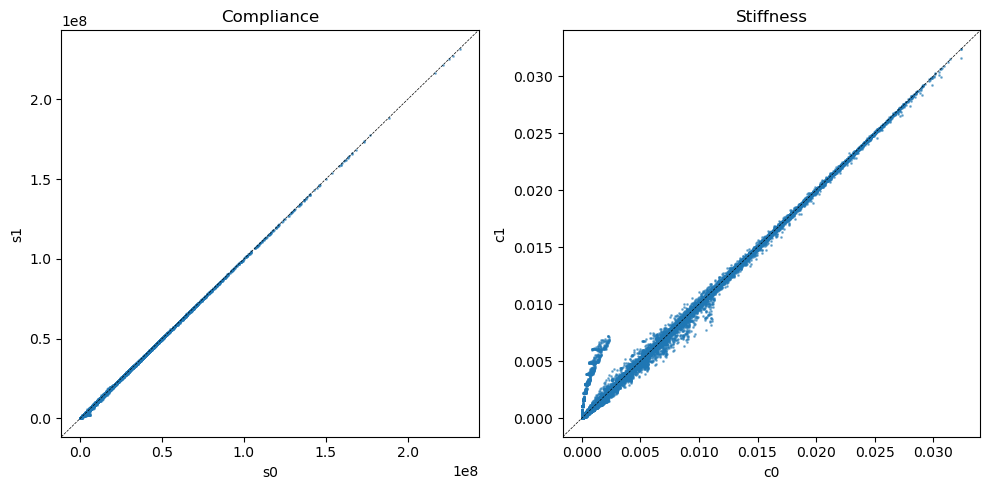

In [45]:
# parity plots 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].scatter(s0.flatten(), s1.flatten(), s=1, alpha=0.5)
axs[0].set_xlabel('s0')
axs[0].set_ylabel('s1')
axs[0].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
axs[0].set_title('Compliance')
axs[1].scatter(c0.flatten(), c1.flatten(), s=1, alpha=0.5)
axs[1].set_xlabel('c0')
axs[1].set_ylabel('c1')
axs[1].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
axs[1].set_title('Stiffness')
plt.tight_layout()
plt.show()

In [47]:
print(s0.shape)
print(rel_dens.shape)

(9041, 10, 100)
(9041, 10)


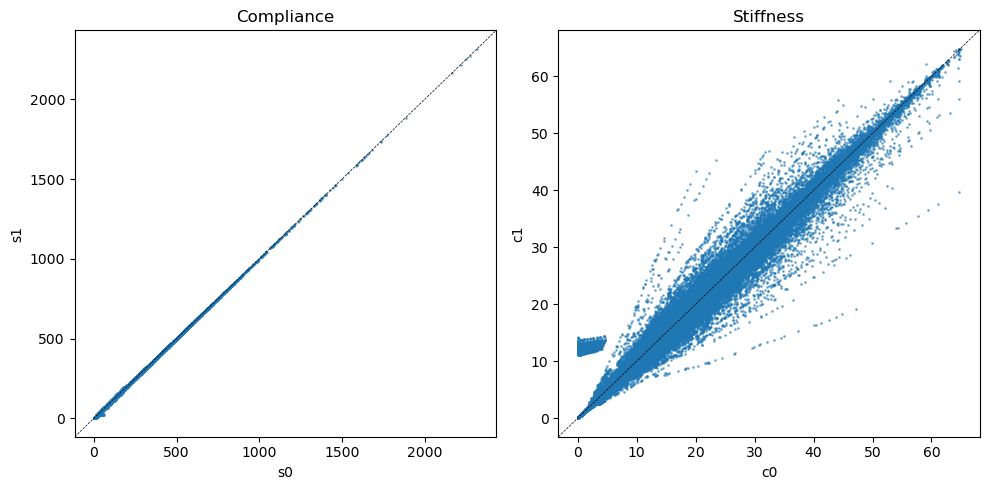

In [74]:
# with normalization
s0_normed = s0*rel_dens[:,:,None]/100
s1_normed = s1*rel_dens[:,:,None]/100
c0_normed = c0/rel_dens[:,:,None]*100
c1_normed = c1/rel_dens[:,:,None]*100
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].scatter(s0_normed, s1_normed, s=1, alpha=0.5)
axs[0].set_xlabel('s0')
axs[0].set_ylabel('s1')
axs[0].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
axs[0].set_title('Compliance')
axs[1].scatter(c0_normed, c1_normed, s=1, alpha=0.5)
axs[1].set_xlabel('c0')
axs[1].set_ylabel('c1')
axs[1].set_title('Stiffness')
axs[1].axline((0,0), slope=1, color='k', linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

In [66]:
rows, cols = np.triu_indices(6)

In [73]:
# losses as in ML
# 1. stiffness loss
print('Stiffness loss. In our best runs we achieve approx. 0.34')
print(torch.nn.functional.l1_loss(torch.from_numpy(C0_plot[:, rows, cols]), torch.from_numpy(C1_plot[:, rows, cols])))

# 2. compliance loss
print('Compliance loss. In our best runs we achieve approx. 0.42')
print(torch.log(1+torch.nn.functional.mse_loss(torch.from_numpy(S0_plot[:, rows, cols]), torch.from_numpy(S1_plot[:, rows, cols]), reduction='none')).mean())

# 3. stiffness projection loss
print('Stiffness projection loss. In our best runs we achieve approx. 0.6')
print(torch.nn.functional.l1_loss(torch.from_numpy(c0_normed), torch.from_numpy(c1_normed)))

# 4. Young's modulus loss
print('Young\'s modulus loss. In our best runs we achieve approx. 0.7, but nor very smooth')
print(torch.nn.functional.l1_loss(torch.from_numpy(1/s0_normed), torch.from_numpy(1/s1_normed)))

# 5. Identity loss
print('Identity loss. In our best runs we achieve approx. 0.1')
print(torch.from_numpy((S0_plot@C1_plot)-eye[None,:,:]).flatten().square().mean())

Stiffness loss. In our best runs we achieve approx. 0.34
tensor(0.0194, dtype=torch.float64)
Compliance loss. In our best runs we achieve approx. 0.42
tensor(0.0045, dtype=torch.float64)
Stiffness projection loss. In our best runs we achieve approx. 0.6
tensor(0.0577, dtype=torch.float64)
Young's modulus loss. In our best runs we achieve approx. 0.7, but nor very smooth
tensor(0.0089, dtype=torch.float64)
Identity loss. In our best runs we achieve approx. 0.1
tensor(0.3624, dtype=torch.float64)
